In [6]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras import optimizers

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


# Facial Expression Recognition

### 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [7]:
def pre_pro():
    
    
    data1 = pd.read_csv('./fer2013.csv')
    
    # Removendo as expressoes Angry=0 e Disgust=1
    data1  = data1[data1['emotion'] != 1]
    data1  = data1[data1['emotion'] != 0]
    
     
    # Alterando os labels das expressoes Surprise de 5 para 0 e Neutral de 6 para 1 
    data1['emotion'] = data1['emotion'].replace(5, 0) 
    data1['emotion'] = data1['emotion'].replace(6, 1)
    
    
    return data1

In [8]:
def pre_pixels(data):
    # Script para preparar conjuntos de dados, carregar dados e gerar imagens em escala 
    # Crie um diretório e mantenha o arquivo fer2013.csv no diretório. 
    # Dataset original em: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge
   
    data1 = data
    
    """ 
    # Removendo as expressoes Angry=0 e Disgust=1
    data1  = data1[data1['emotion'] != 1]
    data1  = data1[data1['emotion'] != 0]
    
    # Alterando os labels das expressoes Surprise de 5 para 0 e Neutral de 6 para 1 
    data1['emotion'] = data1['emotion'].replace(5, 0) 
    data1['emotion'] = data1['emotion'].replace(6, 1) 
    """


    pixels1 = data1['pixels']

    pix = list(pixels1)
    pix1 = pd.DataFrame(pix)
    pix2 = pix1.iloc[:,0].str.split(' ', expand=True)
    df = pix2
    
  
    # Normalização
    scaler = MinMaxScaler()
    df_n = scaler.fit_transform(df)
    
    # Salva os dados em formato numpy
    np.save('data/normalize.bin.npy',df_n)
    
    print("Shape pixels")
    print(df_n.shape)

In [11]:
def pre_emotions (data):
    
    
    data1 = data['emotion']


    """# Removendo as expressoes Angry=0 e Disgust=1
    data1  = data1[data1['emotion'] != 1]
    data1  = data1[data1['emotion'] != 0]

    # Alterando os labels das expressoes Surprise de 5 para 0 e Neutral de 6 para 1 
    data1['emotion'] = data1['emotion'].replace(5, 0) 
    data1['emotion'] = data1['emotion'].replace(6, 1) """
    
    data = np.array(data1)
    data = data.astype('float64')

  

    np.save('./emotion.bin.npy',data)
    
    print("Shape emotion")
    print(data.shape)

In [ ]:
############ Caso queira executar o pré-processamento novamente descomente as lihna abaixo (pode demorar um pouco para executar)


#data = pre_pro()
#print("pre_pro ok")
#pre_pixels(data)
#print("pre_pix ok")
#pre_emotions(data)
#print("pre_emo ok")

# Carregando dados

In [13]:
X_train = np.load('./data/normalize.bin.npy')
labels = np.load('./emotion.bin.npy')


In [14]:
X_train.shape

(30387, 2304)

In [15]:
labels.shape

(30387,)

In [16]:
# one hot encoding
labels = pd.DataFrame(labels)
labels = np_utils.to_categorical(labels)

# Dividindo dados de treinamento, validadação e teste

In [17]:
num = len(X_train)
train = int ( num  * 0.7)
val = int ( num  * 0.8)
num

30387

In [18]:
X_trainn = X_train[:train]
X_val = X_train[train:val]
X_test = X_train[val:]

total = (len(X_trainn)+  len(X_val)+ len(X_test))

print("Dados de trainamento: %s, val: %s e teste: %s"%(len(X_trainn), len(X_val), len(X_test)))
total


X_trainn = X_trainn.reshape(X_trainn.shape[0] ,  48 , 48,1)
X_val = X_val.reshape(X_val.shape[0] ,  48 , 48,1)
X_test = X_test.reshape(X_test.shape[0] ,  48 , 48,1)

Dados de trainamento: 21270, val: 3039 e teste: 6078


In [19]:
y_train = labels[:train]
y_val = labels[train:val]
y_test = labels[val:]

total = (len(y_train)+  len(y_val)+ len(y_test))
total

print("lables: %s, val: %s e teste: %s"%(len(y_train), len(y_val), len(y_test)))

lables: 21270, val: 3039 e teste: 6078


# Exibindo imagem 

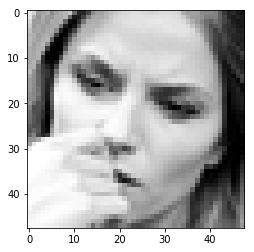

In [20]:
X_train = X_train.reshape(X_train.shape[0] ,  48 , 48)
#X_train2 = X_train.reshape(X_train.shape[0] ,  48 , 48, 1)

plt.imshow(X_train[0], cmap="gray")
plt.show()

# Modelo

In [24]:
model = Sequential()

model.add(Conv2D(128, (3,3), input_shape = (48,48,1),padding="valid", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3,3), activation='relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))



model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation = 'softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 128)       1280      
_________________________________________________________________
batch_normalization_4 (Batch (None, 46, 46, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 23, 23, 64)        73792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 64)        0         
__________

In [27]:
opt = optimizers.Adam(lr=0.001);
#optm = optimizers.RMSprop(lr=0.004, rho=0.9, epsilon=1e-08, decay=0.0)
#sgd = optimizers.SGD(lr=0.055, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Salvando o melhor modelo (melhor conjunto de pesos)
check = ModelCheckpoint(filepath='weights_203.hdf5', verbose=1, save_best_only=True)
early = EarlyStopping(monitor='val_loss',patience=7)
tensorboard = TensorBoard(log_dir='./logs')

model.fit(X_trainn, y_train, batch_size=100 , epochs=50, validation_data=[X_val, y_val], callbacks=[check, early, tensorboard])


Train on 21270 samples, validate on 3039 samples
Epoch 1/50
21270/21270 [==============================] - 41s 2ms/step - loss: 0.4964 - acc: 0.8124 - val_loss: 0.9254 - val_acc: 0.6578

Epoch 00001: val_loss improved from inf to 0.92539, saving model to weights_203.hdf5
Epoch 2/50
21270/21270 [==============================] - 41s 2ms/step - loss: 0.4827 - acc: 0.8142 - val_loss: 0.9515 - val_acc: 0.6660

Epoch 00002: val_loss did not improve from 0.92539
Epoch 3/50
21270/21270 [==============================] - 41s 2ms/step - loss: 0.4732 - acc: 0.8204 - val_loss: 1.0052 - val_acc: 0.6561

Epoch 00003: val_loss did not improve from 0.92539
Epoch 4/50
21270/21270 [==============================] - 42s 2ms/step - loss: 0.4532 - acc: 0.8272 - val_loss: 0.9510 - val_acc: 0.6598

Epoch 00004: val_loss did not improve from 0.92539
Epoch 5/50
21270/21270 [==============================] - 42s 2ms/step - loss: 0.4455 - acc: 0.8311 - val_loss: 0.9572 - val_acc: 0.6578

Epoch 00005: val_loss d

In [ ]:
#model.load_weights('./weights.hdf5')

In [ ]:
########## Caso Deseje salvar uma nova arquitura, descomente as linha abaixo 
#import h5py
#json_string = model.to_json()
#open('models/model_arch.json', 'w').write(json_string)

In [32]:
predictions = model.predict(X_test)
predictions.shape

(6078, 5)

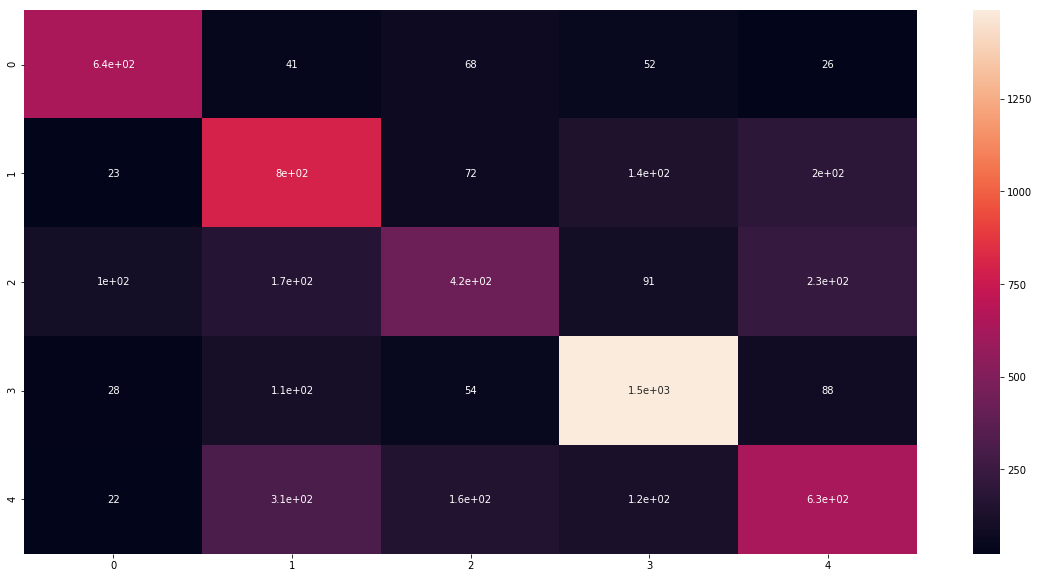

In [33]:
import seaborn as sn
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
matrix
plt.figure(figsize = (20,10))
sn.heatmap(matrix, annot=True)

In [34]:
target_names = ['Surprise', 'Neutral', 'Fear', 'Happy', 'Sad' ]
#print(classification_report(y_test, predictions, target_names=target_names))

In [35]:
def plott():
    normalize=False
    title=None
    cmap=plt.cm.Blues
    cm = matrix
    classes = target_names

    fig, ax = plt.subplots(figsize = (20,10))
    im = ax.imshow(matrix, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, format(matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if matrix[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

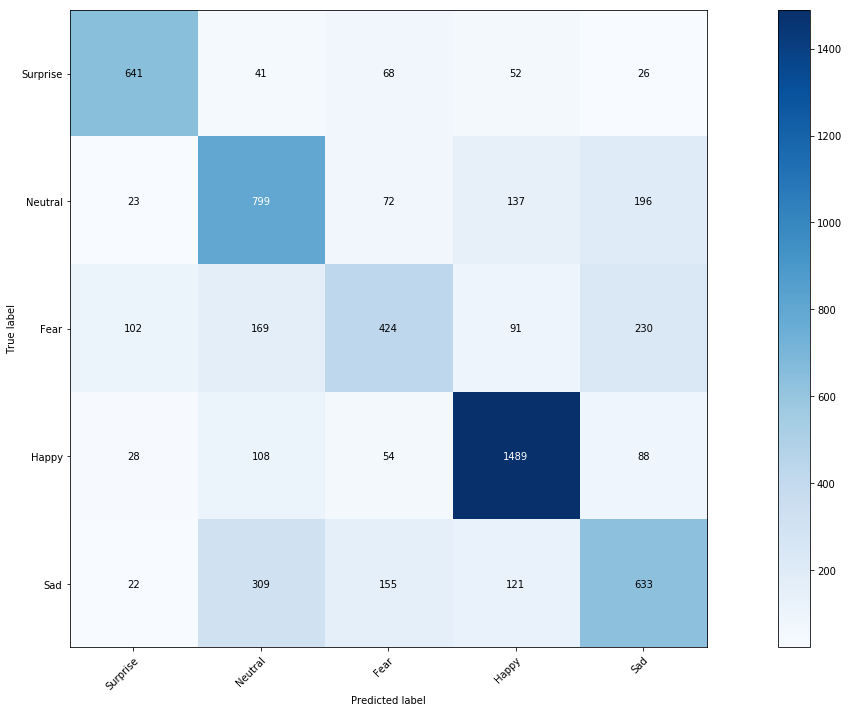

In [36]:
plott()